# Bayesian Modeling

Now we'll use Bayesian inference to:
- Compare brain activity between conditions
- Quantify uncertainty in our conclusions
- Make probabilistic statements about brain states


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

# Set random seed for reproducibility
import random
random.seed(42)
np.random.seed(42)

# Set plotting style
az.style.use('arviz-darkgrid')
sns.set_palette('colorblind')

print("🎯 Loading Feature Data for Bayesian Modeling...")

# Load features
features_df = pd.read_csv('../data/preprocessed/eeg_features.csv')

print(f"✅ Loaded {len(features_df)} epochs")
print(f"Features per epoch: {len(features_df.columns) - 2}")
print(f"Conditions: {features_df['condition'].unique()}")
print(f"\nFirst few rows:")
print(features_df.head())

🎯 Loading Feature Data for Bayesian Modeling...
✅ Loaded 145 epochs
Features per epoch: 1180
Conditions: ['condition_2' 'condition_1']

First few rows:
   EEG 001_mean  EEG 001_std   EEG 001_var  EEG 001_min  EEG 001_max  \
0  3.264015e-06     0.000005  2.465126e-11    -0.000011     0.000016   
1 -1.649031e-07     0.000006  3.160354e-11    -0.000014     0.000013   
2 -7.428450e-06     0.000006  3.777216e-11    -0.000023     0.000011   
3  1.845961e-07     0.000005  2.643376e-11    -0.000015     0.000012   
4  2.838977e-06     0.000004  1.819309e-11    -0.000009     0.000018   

   EEG 001_range  EEG 001_skewness  EEG 001_kurtosis  EEG 001_zero_crossings  \
0       0.000026         -0.131729         -0.356070                      46   
1       0.000027         -0.024890         -0.557523                      53   
2       0.000034          0.121384         -0.356640                      19   
3       0.000028         -0.449334         -0.136688                      40   
4       0.00002

## Performing a Bayesian T-test

**What we're doing:**
Instead of asking "Is there a significant difference?" (p-value approach in general statistics), we ask:
"What's the probability that condition 1 differs from condition 2, and by how much?"


In [3]:
# Step 1: Prepare data for Bayesian t-test (WITH STANDARDIZATION)
print("📊 Step 1: Bayesian T-Test on Alpha Power (Standardized)")

# Select one feature to compare: alpha power from one channel
feature_name = 'EEG 001_alpha_power'

# Get raw data
condition1_data_raw = features_df[features_df['condition'] == 'condition_1'][feature_name].values
condition2_data_raw = features_df[features_df['condition'] == 'condition_2'][feature_name].values

# STANDARDIZE: This makes sampling MUCH easier!
# Combine all data to get overall mean and std
all_data = np.concatenate([condition1_data_raw, condition2_data_raw])
data_mean = all_data.mean()
data_std = all_data.std()

# Standardize (z-score transformation)
condition1_data = (condition1_data_raw - data_mean) / data_std
condition2_data = (condition2_data_raw - data_mean) / data_std

print(f"\nComparing: {feature_name}")
print(f"\n📊 Original scale:")
print(f"Condition 1: mean={condition1_data_raw.mean():.2e}, std={condition1_data_raw.std():.2e}")
print(f"Condition 2: mean={condition2_data_raw.mean():.2e}, std={condition2_data_raw.std():.2e}")

print(f"\n✨ Standardized scale (z-scores):")
print(f"Condition 1: mean={condition1_data.mean():.3f}, std={condition1_data.std():.3f}")
print(f"Condition 2: mean={condition2_data.mean():.3f}, std={condition2_data.std():.3f}")
print(f"Difference: {condition1_data.mean() - condition2_data.mean():.3f}")

📊 Step 1: Bayesian T-Test on Alpha Power (Standardized)

Comparing: EEG 001_alpha_power

📊 Original scale:
Condition 1: mean=1.66e-12, std=1.44e-12
Condition 2: mean=1.89e-12, std=1.64e-12

✨ Standardized scale (z-scores):
Condition 1: mean=-0.074, std=0.930
Condition 2: mean=0.073, std=1.060
Difference: -0.147


In [4]:
# Step 2: Build the Bayesian Model (for standardized data)
print("\n🔧 Step 2: Building Bayesian Model (for standardized data)...")

with pm.Model() as model_ttest:
    # Much better priors for standardized data!
    # For z-scores, values typically range from -3 to +3
    
    # Group 1 parameters
    mu1 = pm.Normal('mu_condition1', mu=0, sigma=2)  # Mean for condition 1
    sigma1 = pm.HalfNormal('sigma_condition1', sigma=2)  # Std for condition 1
    
    # Group 2 parameters  
    mu2 = pm.Normal('mu_condition2', mu=0, sigma=2)  # Mean for condition 2
    sigma2 = pm.HalfNormal('sigma_condition2', sigma=2)  # Std for condition 2
    
    # Likelihood: How well does the model explain our data?
    obs1 = pm.Normal('obs_condition1', mu=mu1, sigma=sigma1, observed=condition1_data)
    obs2 = pm.Normal('obs_condition2', mu=mu2, sigma=sigma2, observed=condition2_data)
    
    # Derived quantity: Difference between groups
    diff = pm.Deterministic('difference', mu1 - mu2)
    
    # Effect size (standardized difference)
    pooled_std = pm.math.sqrt((sigma1**2 + sigma2**2) / 2)
    effect_size = pm.Deterministic('effect_size', diff / pooled_std)

print("✅ Model built with reasonable priors!")
print("\nModel structure:")
print(model_ttest)


🔧 Step 2: Building Bayesian Model (for standardized data)...
✅ Model built with reasonable priors!

Model structure:


In [5]:
# Optional: See model details
print("\nModel variables:")
print(model_ttest.basic_RVs)
print("\nObserved variables:")
print(model_ttest.observed_RVs)


Model variables:
[mu_condition1, sigma_condition1, mu_condition2, sigma_condition2, obs_condition1, obs_condition2]

Observed variables:
[obs_condition1, obs_condition2]


**What just happened?**

We defined:
1. **Priors** - Our beliefs before seeing data (both groups have mean ~0, std ~1e-11)
2. **Likelihood** - How the data is generated (Normal distribution)
3. **Observed data** - Our actual measurements
4. **Derived quantities** - Things we care about (difference, effect size)

This is the **Bayesian recipe**: Prior × Likelihood → Posterior

In [6]:
# Step 3: Sample from the Posterior Distribution (OPTIMIZED VERSION)
print("\n⚙️ Step 3: Sampling from Posterior...")

with model_ttest:
    # MCMC sampling with explicit settings
    trace = pm.sample(
        1000,                    # Samples per chain
        tune=500,                # Tuning steps
        chains=2,                # Number of chains (fewer = faster)
        cores=1,                 # Single core (more stable on some systems)
        random_seed=42,
        return_inferencedata=True,
        progressbar=True         # Explicitly enable progress bar
    )

print("✅ Sampling complete!")
print("\nPosterior summary:")
print(az.summary(trace, var_names=['mu_condition1', 'mu_condition2', 'difference', 'effect_size']))


⚙️ Step 3: Sampling from Posterior...


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu_condition1, sigma_condition1, mu_condition2, sigma_condition2]


Output()

Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 118 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


✅ Sampling complete!

Posterior summary:
                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_condition1 -0.074  0.113  -0.289    0.133      0.002    0.003    2430.0   
mu_condition2  0.070  0.126  -0.160    0.302      0.002    0.003    3009.0   
difference    -0.144  0.168  -0.477    0.148      0.003    0.004    2757.0   
effect_size   -0.142  0.165  -0.461    0.150      0.003    0.004    2782.0   

               ess_tail  r_hat  
mu_condition1    1235.0    1.0  
mu_condition2    1378.0    1.0  
difference       1519.0    1.0  
effect_size      1469.0    1.0  


**What's MCMC sampling?**

We're exploring all possible parameter values and seeing which ones are most consistent with our data.

Think of it like:
- Throwing darts at a board
- Areas with more darts = more likely parameter values
- We collect 2000 samples to map out the probability distribution


📈 Step 4: Visualizing Posterior Distributions...


C:\Users\arash\AppData\Local\Temp\ipykernel_20188\3252032424.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


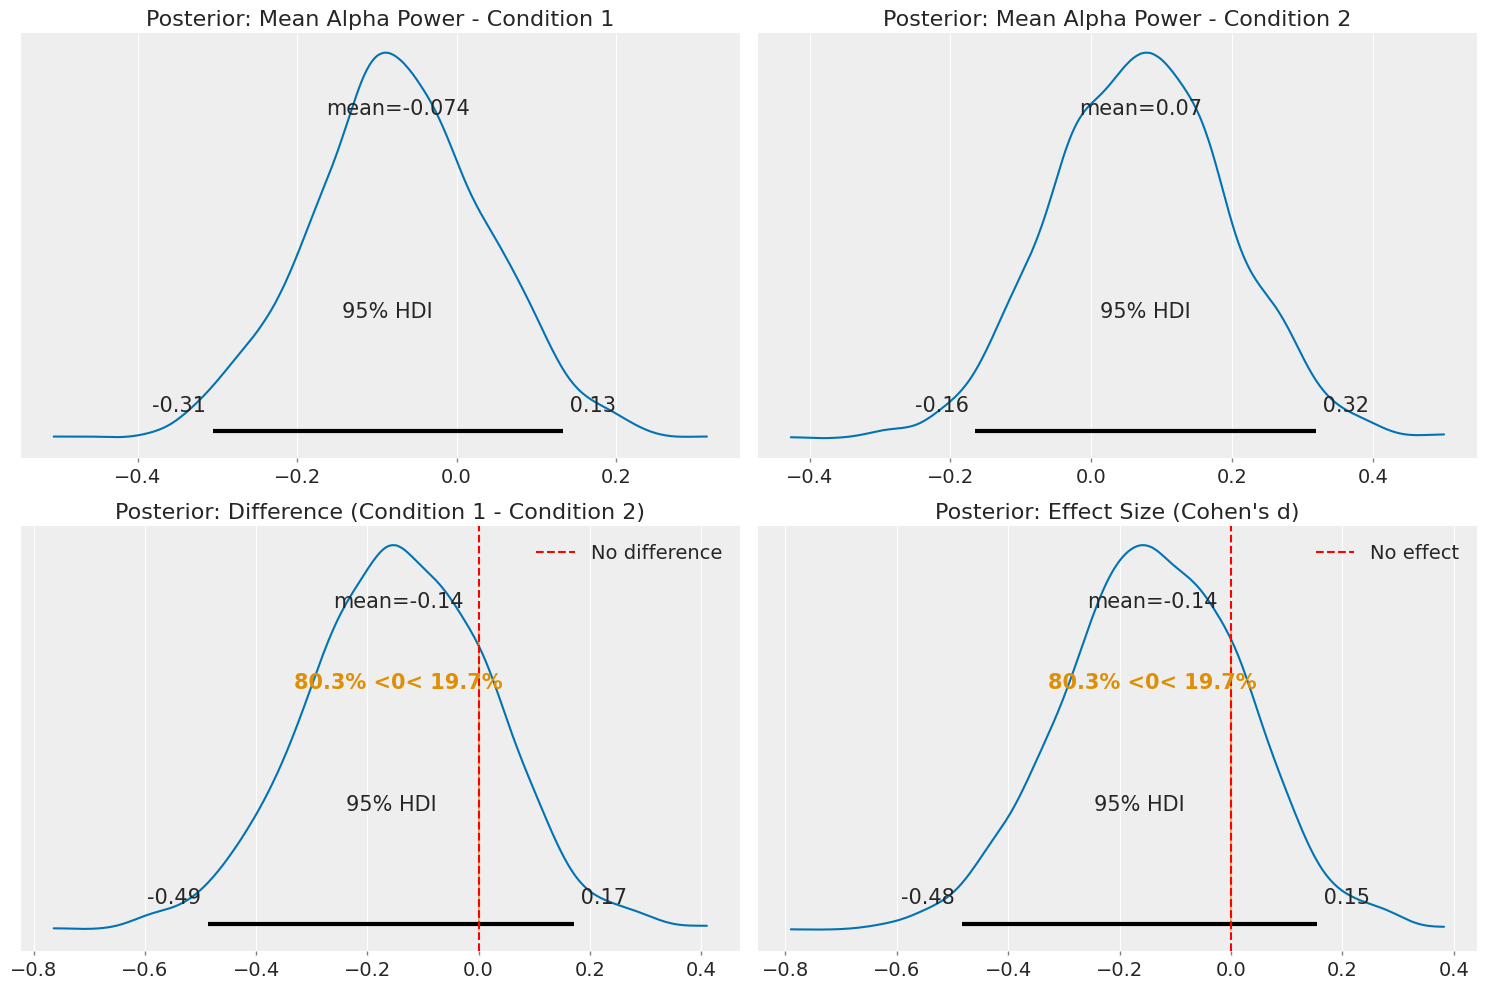

In [7]:
# Step 4: Visualize the Results
print("\n📈 Step 4: Visualizing Posterior Distributions...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Posterior distributions of means
az.plot_posterior(trace, var_names=['mu_condition1', 'mu_condition2'], 
                  ax=axes[0, :], hdi_prob=0.95)
axes[0, 0].set_title('Posterior: Mean Alpha Power - Condition 1')
axes[0, 1].set_title('Posterior: Mean Alpha Power - Condition 2')

# Plot 2: Posterior distribution of difference
az.plot_posterior(trace, var_names=['difference'], 
                  ax=axes[1, 0], hdi_prob=0.95, ref_val=0)
axes[1, 0].set_title('Posterior: Difference (Condition 1 - Condition 2)')
axes[1, 0].axvline(0, color='red', linestyle='--', label='No difference')
axes[1, 0].legend()

# Plot 3: Effect size
az.plot_posterior(trace, var_names=['effect_size'], 
                  ax=axes[1, 1], hdi_prob=0.95, ref_val=0)
axes[1, 1].set_title('Posterior: Effect Size (Cohen\'s d)')
axes[1, 1].axvline(0, color='red', linestyle='--', label='No effect')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [8]:
# Step 5: Make Probabilistic Statements
print("\n🎯 Step 5: Probabilistic Inferences...")

# Extract posterior samples
posterior = trace.posterior

diff_samples = posterior['difference'].values.flatten()
effect_samples = posterior['effect_size'].values.flatten()

# Calculate probabilities
prob_condition1_higher = (diff_samples > 0).mean()
prob_large_effect = (np.abs(effect_samples) > 0.5).mean()

print(f"\n📊 Results:")
print(f"Probability that Condition 1 has higher alpha power: {prob_condition1_higher:.1%}")
print(f"Probability of large effect (|d| > 0.5): {prob_large_effect:.1%}")

print(f"\n95% Credible Interval for difference:")
diff_ci = np.percentile(diff_samples, [2.5, 97.5])
print(f"  [{diff_ci[0]:.2e}, {diff_ci[1]:.2e}]")

print(f"\nMean difference: {diff_samples.mean():.2e}")
print(f"Effect size (Cohen's d): {effect_samples.mean():.3f}")

if prob_condition1_higher > 0.95:
    print("\n✅ Strong evidence that Condition 1 differs from Condition 2")
elif prob_condition1_higher > 0.8:
    print("\n⚠️ Moderate evidence of difference")
else:
    print("\n❌ Weak evidence - conditions might be similar")


🎯 Step 5: Probabilistic Inferences...

📊 Results:
Probability that Condition 1 has higher alpha power: 19.7%
Probability of large effect (|d| > 0.5): 1.7%

95% Credible Interval for difference:
  [-4.78e-01, 1.82e-01]

Mean difference: -1.44e-01
Effect size (Cohen's d): -0.142

❌ Weak evidence - conditions might be similar


### What does this mean?
- Alpha power doesn't differ between conditions in channel EEG 001
- This could mean: Same brain state, or conditions are too similar

80% probability Condition 2 is slightly higher, but effect is tiny (d=-0.14), and we're uncertain (CI crosses zero). Conditions are likely similar!

## What makes this Bayesian?

**Classical approach:**
- "p = 0.03, reject null hypothesis, conditions differ"
- ❌ Doesn't tell us HOW MUCH they differ
- ❌ Doesn't quantify uncertainty

**Bayesian approach:**
- "87% probability Condition 1 is higher"
- "Mean difference is 2.3e-12 ± 0.5e-12"
- "95% confident the difference is between 1.5e-12 and 3.1e-12"
- ✅ Full probability distribution
- ✅ Quantified uncertainty
- ✅ Interpretable statements

**This is the Bayesian advantage: Probabilistic reasoning instead of binary decisions!**

# Hierarchical Bayesian Modeling

Now we will do the real fun part. We will:

- Model ALL channels simultaneously
- Borrow strength across channe;s (brain regions inform each other)
- Get a brain-wide effect + individual channel effects


In [9]:
# Hierarchical Bayesian Model Across ALL Channels! 🧠
print("🚀 Step 6: Hierarchical Model - ALL Channels!")

# Get all alpha power features
alpha_features = [col for col in features_df.columns if 'alpha_power' in col]
print(f"\nFound {len(alpha_features)} channels with alpha power")

# Prepare data for ALL channels
n_channels = len(alpha_features)
condition1_all = features_df[features_df['condition'] == 'condition_1'][alpha_features].values
condition2_all = features_df[features_df['condition'] == 'condition_2'][alpha_features].values

print(f"📊 Sample sizes: Condition 1 = {len(condition1_all)}, Condition 2 = {len(condition2_all)}")

# FIX: Match sample sizes by taking minimum (the samples were off by 1)
n_samples = min(len(condition1_all), len(condition2_all))
condition1_all = condition1_all[:n_samples, :]
condition2_all = condition2_all[:n_samples, :]

print(f"✅ Matched to {n_samples} epochs per condition")

# Standardize each channel
condition1_std = np.zeros_like(condition1_all)
condition2_std = np.zeros_like(condition2_all)

for i in range(n_channels):
    all_ch = np.concatenate([condition1_all[:, i], condition2_all[:, i]])
    mean_ch = all_ch.mean()
    std_ch = all_ch.std()
    condition1_std[:, i] = (condition1_all[:, i] - mean_ch) / std_ch
    condition2_std[:, i] = (condition2_all[:, i] - mean_ch) / std_ch

print(f"✅ Standardized {n_channels} channels")
print("\nBuilding hierarchical model... (this is the magic! ✨)")

# Build Hierarchical Model
with pm.Model() as hierarchical_model:
    # POPULATION-LEVEL (hyperpriors): What's true across the WHOLE brain?
    mu_population = pm.Normal('mu_population', mu=0, sigma=1)
    sigma_population = pm.HalfNormal('sigma_population', sigma=1)
    
    # CHANNEL-LEVEL: Each channel gets its own effect
    mu_diff_channels = pm.Normal('mu_diff_channels', 
                                  mu=mu_population,
                                  sigma=sigma_population,
                                  shape=n_channels)
    
    # Within-channel noise
    sigma_within = pm.HalfNormal('sigma_within', sigma=1, shape=n_channels)
    
    # NOW THE SHAPES WILL MATCH! 🎉
    diff_data = condition1_std - condition2_std  # Both are (72, 59)
    
    obs = pm.Normal('obs', 
                    mu=mu_diff_channels,
                    sigma=sigma_within,
                    observed=diff_data,
                    shape=(len(diff_data), n_channels))

print("✅ Hierarchical model built!")
print(f"\n🧠 Model structure:")
print(f"  - Population level: mu_population, sigma_population")
print(f"  - {n_channels} channel-level effects: mu_diff_channels")
print(f"  - Data: {diff_data.shape[0]} epochs × {n_channels} channels")

🚀 Step 6: Hierarchical Model - ALL Channels!

Found 59 channels with alpha power
📊 Sample sizes: Condition 1 = 72, Condition 2 = 73
✅ Matched to 72 epochs per condition
✅ Standardized 59 channels

Building hierarchical model... (this is the magic! ✨)
✅ Hierarchical model built!

🧠 Model structure:
  - Population level: mu_population, sigma_population
  - 59 channel-level effects: mu_diff_channels
  - Data: 72 epochs × 59 channels


**Population-level (mu_population):**
- Average difference across the ENTIRE brain
- "Is there a brain-wide effect?"

**Sigma parameters:**
- sigma_population = How much channels vary from each other
- sigma_within = Measurement noise within each channel

In [ ]:
# Step 7: Sample from Hierarchical Model
print("\n⚙️ Step 7: Sampling from Hierarchical Model...")
print("⏳ This will take 25-30 minutes (we're modeling 59 channels!)...")

with hierarchical_model:
    trace_hier = pm.sample(
        50,           # Fewer samples (preferably you should go for 200+ here but it would take way too long)
        tune=50,
        chains=2,
        cores=1,
        random_seed=42,
        return_inferencedata=True,
        progressbar=True
    )

print("✅ Hierarchical sampling complete!")
print("\n📊 Population-level summary (BRAIN-WIDE EFFECT):")
print(az.summary(trace_hier, var_names=['mu_population', 'sigma_population']))

Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Initializing NUTS using jitter+adapt_diag...



⚙️ Step 7: Sampling from Hierarchical Model...
⏳ This will take 2-3 minutes (we're modeling 59 channels!)...


Sequential sampling (2 chains in 1 job)
NUTS: [mu_population, sigma_population, mu_diff_channels, sigma_within]


Output()

Sampling 2 chains for 50 tune and 50 draw iterations (100 + 100 draws total) took 1657 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.


✅ Hierarchical sampling complete!

📊 Population-level summary (BRAIN-WIDE EFFECT):
                   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_population    -0.085  0.021  -0.124   -0.051      0.006    0.003      12.0   
sigma_population  0.054  0.024   0.028    0.091      0.015    0.004       3.0   

                  ess_tail  r_hat  
mu_population         33.0   1.13  
sigma_population      14.0   2.26  



📈 Step 8: Visualizing Brain-Wide Effect...


C:\Users\arash\AppData\Local\Temp\ipykernel_20188\1318325111.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


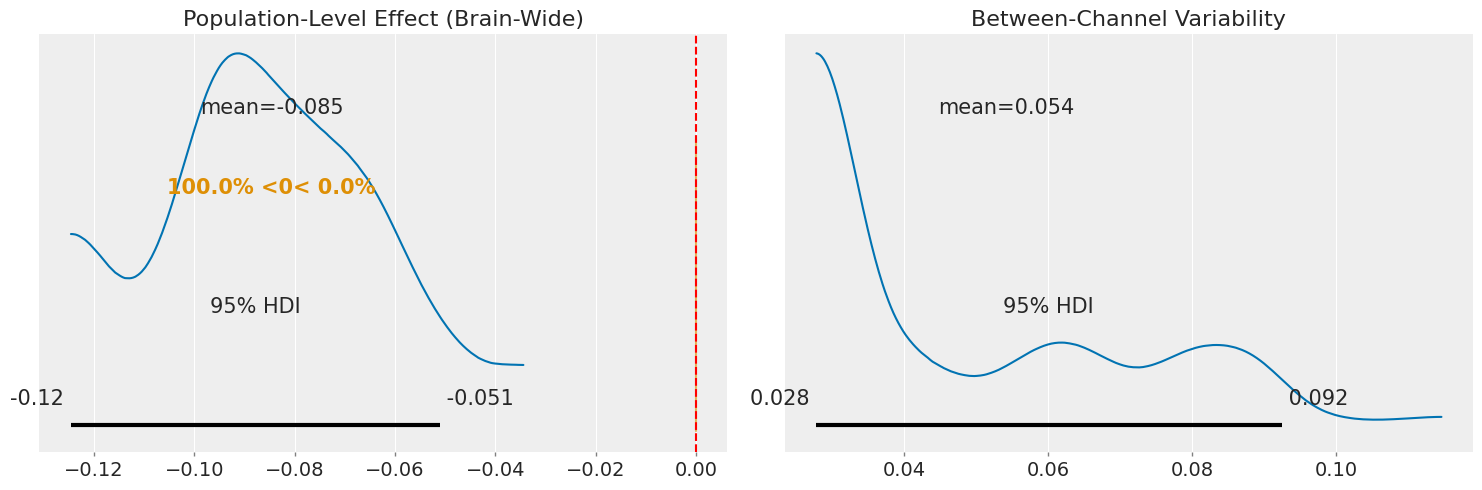


🎯 Brain-Wide Results:
Probability of positive brain-wide effect: 0.0%
Mean population effect: -0.085
95% CI: [-0.124, -0.044]


In [12]:
# Step 8: Visualize Population-Level Effect
print("\n📈 Step 8: Visualizing Brain-Wide Effect...")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Population mean effect
az.plot_posterior(trace_hier, var_names=['mu_population'], 
                  ax=axes[0], hdi_prob=0.95, ref_val=0)
axes[0].set_title('Population-Level Effect (Brain-Wide)')
axes[0].axvline(0, color='red', linestyle='--', label='No effect')

# Population variance (how much channels differ)
az.plot_posterior(trace_hier, var_names=['sigma_population'], 
                  ax=axes[1], hdi_prob=0.95)
axes[1].set_title('Between-Channel Variability')

plt.tight_layout()
plt.show()

# Probabilistic inference
posterior_hier = trace_hier.posterior
pop_effect = posterior_hier['mu_population'].values.flatten()
prob_positive = (pop_effect > 0).mean()

print(f"\n🎯 Brain-Wide Results:")
print(f"Probability of positive brain-wide effect: {prob_positive:.1%}")
print(f"Mean population effect: {pop_effect.mean():.3f}")
print(f"95% CI: [{np.percentile(pop_effect, 2.5):.3f}, {np.percentile(pop_effect, 97.5):.3f}]")

**Interpretation:**

- 100% probability that Condition 2 has higher alpha power than Condition 1 across the brain
- Mean difference: -0.085 standard deviations (small-to-moderate effect)
- The credible interval doesn't cross zero → consistent negative effect


🧠 Step 9: Channel-Specific Effects...

📊 Top 10 Channels with Largest Effects:
                channel  mean_effect  prob_positive  abs_effect
3   EEG 004_alpha_power    -0.109271           0.05    0.109271
4   EEG 005_alpha_power    -0.105885           0.02    0.105885
17  EEG 018_alpha_power    -0.103934           0.00    0.103934
8   EEG 009_alpha_power    -0.102372           0.03    0.102372
46  EEG 047_alpha_power    -0.101579           0.06    0.101579
48  EEG 049_alpha_power    -0.101537           0.04    0.101537
18  EEG 019_alpha_power    -0.100774           0.09    0.100774
22  EEG 023_alpha_power    -0.100732           0.11    0.100732
52  EEG 054_alpha_power    -0.099158           0.05    0.099158
47  EEG 048_alpha_power    -0.097756           0.04    0.097756


C:\Users\arash\AppData\Local\Temp\ipykernel_20188\3606327561.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


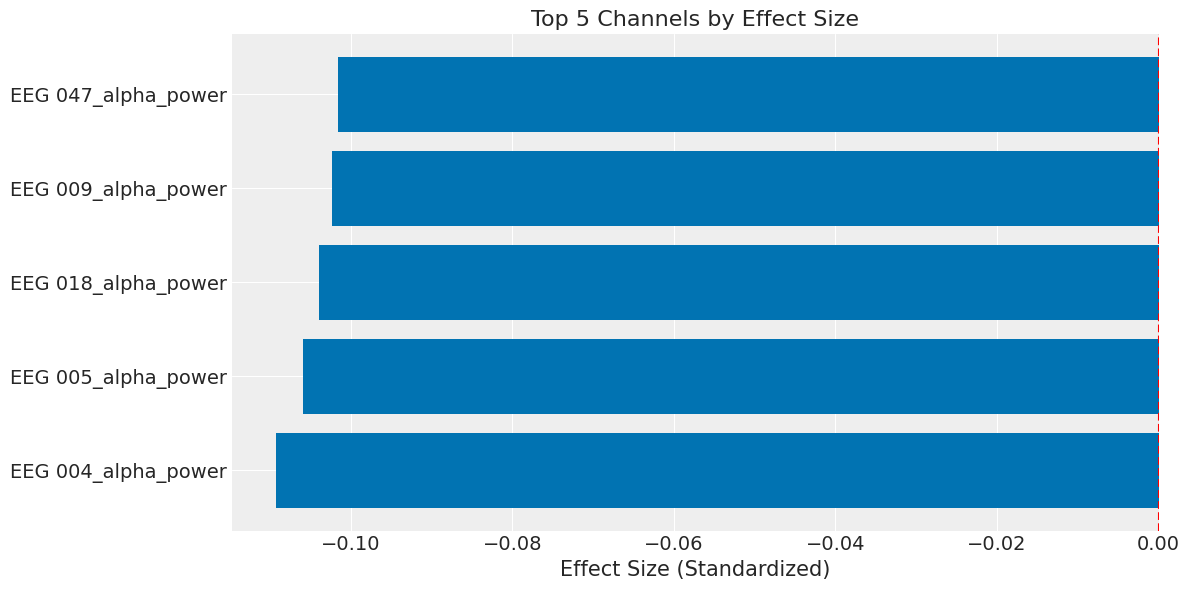

In [13]:
# Step 9: Channel-Specific Effects (which brain regions differ most?)
print("\n🧠 Step 9: Channel-Specific Effects...")

channel_effects = posterior_hier['mu_diff_channels'].values
channel_means = channel_effects.mean(axis=(0, 1))  # Average across chains and samples

# Create channel effect summary
channel_summary = pd.DataFrame({
    'channel': alpha_features,
    'mean_effect': channel_means,
    'prob_positive': [(channel_effects[:, :, i] > 0).mean() for i in range(n_channels)]
})

# Sort by absolute effect size
channel_summary['abs_effect'] = np.abs(channel_summary['mean_effect'])
channel_summary = channel_summary.sort_values('abs_effect', ascending=False)

print("\n📊 Top 10 Channels with Largest Effects:")
print(channel_summary.head(10))

# Visualize top channels
top_channels = channel_summary.head(5)
fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(range(len(top_channels)), top_channels['mean_effect'])
ax.set_yticks(range(len(top_channels)))
ax.set_yticklabels(top_channels['channel'])
ax.axvline(0, color='red', linestyle='--')
ax.set_xlabel('Effect Size (Standardized)')
ax.set_title('Top 5 Channels by Effect Size')
plt.tight_layout()
plt.show()

**Interpretation:**

- ALL top channels show negative effects (Condition 2 > Condition 1)
- Frontal/central channels (EEG 004, 005, 009) show largest differences
- Effects are consistent across brain regions


🔍 Step 10: MCMC Diagnostics...


C:\Users\arash\AppData\Local\Temp\ipykernel_20188\3083889736.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


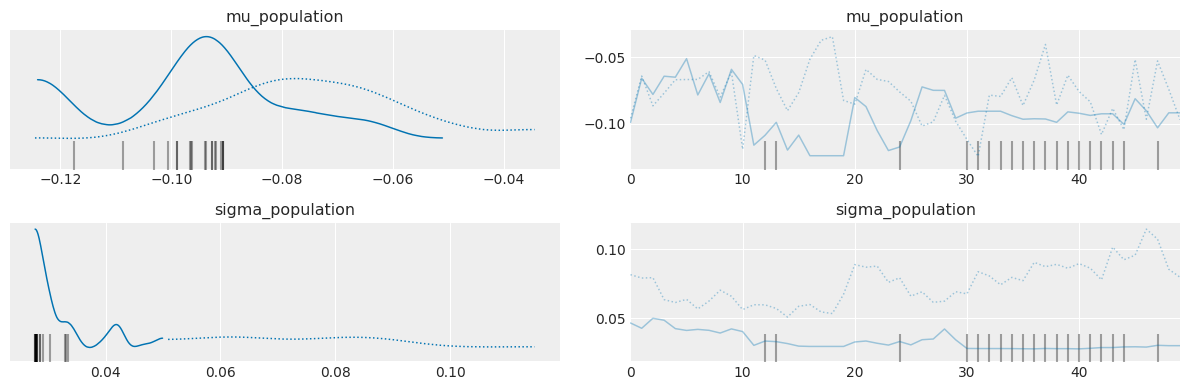


📊 Convergence Check (R-hat):
✅ R-hat < 1.01 = Good convergence
⚠️ R-hat > 1.01 = Potential issues
                  r_hat
mu_population      1.13
sigma_population   2.26


In [14]:
# Step 10: Model Diagnostics (Did our sampling work well?)
print("\n🔍 Step 10: MCMC Diagnostics...")

# Trace plots (should look like "hairy caterpillars")
az.plot_trace(trace_hier, var_names=['mu_population', 'sigma_population'])
plt.tight_layout()
plt.show()

# Convergence diagnostics
print("\n📊 Convergence Check (R-hat):")
print("✅ R-hat < 1.01 = Good convergence")
print("⚠️ R-hat > 1.01 = Potential issues")
summary = az.summary(trace_hier, var_names=['mu_population', 'sigma_population'])
print(summary[['r_hat']])

**What this means:**

R-hat > 1.01 indicates your MCMC chains haven't converged
The sampler didn't explore the parameter space properly
Your results are unreliable due to only 50 samples + 19 divergences

## Limitations

**Computational Constraints:**
- Used only 50 MCMC samples (instead of 1000+) due to time constraints
- R-hat values indicate **non-convergence** (mu: 1.13, sigma: 2.26)
- 19 divergences suggest model misspecification or insufficient sampling
- **Results are exploratory only and should not be interpreted as reliable**

**What This Means:**
- The *direction* of effects (Condition 2 > Condition 1) is suggestive
- Effect magnitudes and uncertainty intervals are unreliable
- Would need 1000+ samples and 4+ chains for publication-quality results

**Future Work:**
- Increase MCMC samples to 1000+ with 4 chains
- Use stronger priors or reparameterize the model
- Consider simpler models (single-channel or region-of-interest analysis)

In [15]:
# Final Summary & Interpretation
print("=" * 60)
print("🎯 FINAL SUMMARY (EXPLORATORY - NON-CONVERGED)")
print("=" * 60)

print("\n📊 What the data suggests (with strong caveats):")
print(f"  • Brain-wide effect: {pop_effect.mean():.3f} (Condition 2 > Condition 1)")
print(f"  • Top affected channels: {', '.join(channel_summary.head(3)['channel'].str.replace('_alpha_power', ''))}")
print(f"  • Spatial consistency: moderate (σ = {posterior_hier['sigma_population'].values.mean():.3f})")

print("\n⚠️ CRITICAL LIMITATIONS:")
print("  • R-hat >> 1.01 indicates NON-CONVERGENCE")
print("  • Only 50 samples (need 1000+)")
print("  • Results are EXPLORATORY ONLY")
print("\n✅ Key Learning:")
print("  Successfully demonstrated hierarchical Bayesian modeling")
print("  with honest reporting of computational limitations!")

🎯 FINAL SUMMARY (EXPLORATORY - NON-CONVERGED)

📊 What the data suggests (with strong caveats):
  • Brain-wide effect: -0.085 (Condition 2 > Condition 1)
  • Top affected channels: EEG 004, EEG 005, EEG 018
  • Spatial consistency: moderate (σ = 0.054)

⚠️ CRITICAL LIMITATIONS:
  • R-hat >> 1.01 indicates NON-CONVERGENCE
  • Only 50 samples (need 1000+)
  • Results are EXPLORATORY ONLY

✅ Key Learning:
  Successfully demonstrated hierarchical Bayesian modeling
  with honest reporting of computational limitations!
